In [1]:
import numpy as np
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [3]:
def calc_std_feat(x: np.array): # функция стандартизации данных
    return (x - x.mean(axis=1).reshape(-1, 1)) / x.std(axis=1).reshape(-1, 1)

In [4]:
X[1:, :] = calc_std_feat(X[1:, :])

In [5]:
X.mean(axis=1), X.std(axis=1)

(array([ 1.,  0., -0.,  0.]), array([0., 1., 1., 1.]))

**Задание 1:** Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log.

In [6]:
def calc_logloss(y, y_pred, precision=1e-8):
    y_pred = y_pred.copy()
    y_pred = np.clip(y_pred, precision, 1 - precision)
    err = - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))
    return err

**Задание 2:** Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [8]:
def eval_model(X, y, iterations, alpha, tol):
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    err_hist, w_hist = [], [W]

    for i in range(1, iterations + 1):
        
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        
        err = calc_logloss(y, y_pred)
        err_hist.append(err)
        
        W = W - alpha * (1 / n * np.dot((y_pred - y), X.T))
        w_hist.append(W)
        
#         if i % (iterations / 1000) == 0:
#             print(i, W, err)
        
        if i > 2 and np.abs(err - err_hist[-2]) < tol:
            break
            
    return i, err, W, w_hist, err_hist

In [9]:
dictionary = {}
tol=1e-6
alpha_values = [10 ** -x for x in range(1, 6)]
iterations_values = [10 ** x for x in range(1, 6)]

In [10]:
for alpha in alpha_values:
    for iterations in iterations_values:
        i, err, W, w_hist, err_hist = eval_model(X, y, iterations=iterations, alpha=alpha, tol=tol)
        dictionary[err] = i, alpha, W, w_hist, err_hist

In [11]:
min_err = min(dictionary.keys()) 
opt_iterations, opt_alpha, opt_W, w_hist, err_hist = dictionary[min_err] # оптимальные параметры

In [12]:
print(f'Функция logloss минимальна при параметрах alpha = {opt_alpha}, iterations = {opt_iterations}, '
      f'точности = {tol} и составляет {min_err}')

Функция logloss минимальна при параметрах alpha = 0.1, iterations = 38962, точности = 1e-06 и составляет 0.10876542150046278


In [13]:
def plot_history(w_hist, err_hist):
    
    fig = plt.figure(figsize=(16, 6))
    
    plt.subplot(121)
    plt.title('Logloss')
    plt.plot(err_hist, linewidth=2)
    plt.xlabel('$iterations$')
    plt.ylabel('$logloss$')
    plt.grid()

    plt.subplot(122)
    plt.title('Weights')
    plt.plot(w_hist, linewidth=2)
    plt.legend([f'$w_{i}$' for i in range(len(w_hist[0]))], loc='best')
    plt.xlabel('$iterations$')
    plt.ylabel('$w$')
    plt.grid()

In [14]:
opt_W

array([  5.12953375, -10.52471566, -10.71446945,  24.88051255])

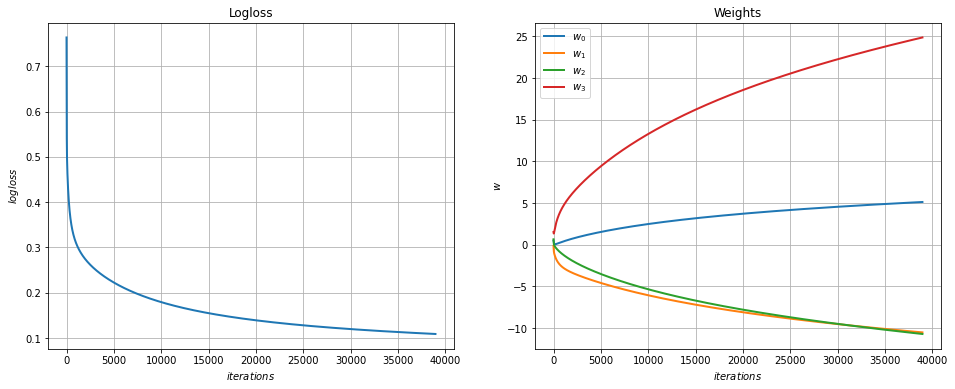

In [15]:
plot_history(w_hist, err_hist)

**Задание 3:** Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [16]:
def y_pred_proba(W, X):
    z = W.dot(X)
    y_pred_proba = sigmoid(z)
    return y_pred_proba

In [17]:
y_pred_proba(opt_W, X)

array([0.34075722, 0.00618638, 1.        , 0.05367898, 0.93626047,
       0.02847029, 1.        , 0.01942685, 0.60942544, 0.99999992])

**Задание 4:** Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [18]:
def calc_pred(W, X, threshold=0.5):
    y_pred = np.where(y_pred_proba(W, X) >= threshold, 1, 0)
    return y_pred

In [19]:
y_pred = calc_pred(opt_W, X)

y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [20]:
y_pred == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

**Задание 5:** Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.


In [21]:
def accuracy(y, y_pred):
    return np.mean(y_pred == y)

In [22]:
def confusion_matrix(y, y_pred):
    matrix = np.zeros((2, 2))
    matrix[0,0] = np.sum(np.where(y == 1, y == y_pred, False))
    matrix[1,1] = np.sum(np.where(y == 0, y == y_pred, False))
    matrix[1,0] = np.sum(np.where(y == 1, y != y_pred, False))
    matrix[0,1] = np.sum(np.where(y == 0, y != y_pred, False))
    return matrix

In [23]:
def precision(y, y_pred):
    matrix = confusion_matrix(y, y_pred)
    return matrix[0, 0] / (matrix[0, 0] + matrix[0, 1])

In [24]:
def recall(y, y_pred):
    matrix = confusion_matrix(y, y_pred)
    return matrix[0, 0] / (matrix[0, 0] + matrix[1, 0])

In [25]:
def f1_score(y, y_pred):
    pr = precision(y, y_pred)
    rc = recall(y, y_pred)
    return 2 * pr * rc / (pr + rc)

In [26]:
accuracy(y, y_pred)

1.0

In [27]:
confusion_matrix(y, y_pred)

array([[5., 0.],
       [0., 5.]])

In [28]:
precision(y, y_pred)

1.0

In [29]:
recall(y, y_pred)

1.0

In [30]:
f1_score(y, y_pred)

1.0

**Задание 6:** Могла ли модель переобучиться? Почему?

Безусловно, могла, т.к. выборка достаточно маленькая, а все коэффициенты регрессии при признаках (не $w_0$) получаются разнонаправленными и большими по модулю. Также в выборке присутствует явный выброс, тем не менее предсказанные классы полностью совпадают с тренировочными.

**Задание 7:** (опция) Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [31]:
def eval_model_l1(X, y, iterations, alpha, tol, lambda_):
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    err_hist, w_hist = [], [W]

    for i in range(1, iterations + 1):
        
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        
        err = calc_logloss(y, y_pred)
        err_hist.append(err)
        
        W = W - alpha * (1 / n * np.dot((y_pred - y), X.T)) - lambda_ * np.sign(W)
        w_hist.append(W)
        
        if i > 2 and np.abs(err - err_hist[-2]) < tol:
            break
            
    return i, err, W, w_hist, err_hist

In [32]:
def eval_model_l2(X, y, iterations, alpha, tol, lambda_):
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    
    err_hist, w_hist = [], [W]

    for i in range(1, iterations + 1):
        
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        
        err = calc_logloss(y, y_pred)
        err_hist.append(err)
        
        W = W - alpha * (1 / n * np.dot((y_pred - y), X.T)) - 2 * lambda_ * W
        w_hist.append(W)
        
        if i > 2 and np.abs(err - err_hist[-2]) < tol:
            break
            
    return i, err, W, w_hist, err_hist

**L1-регуляризация:**

In [33]:
i, err, W, w_hist, err_hist = eval_model_l1(X, y, iterations=opt_iterations, alpha=opt_alpha, tol=tol, lambda_=1e-3)

print(f'При добавлении L1-регуляризации logloss = {err} количество итераций = {i} при точности {tol} и alpha = {opt_alpha}')

При добавлении L1-регуляризации logloss = 0.2856489782461794 количество итераций = 8054 при точности 1e-06 и alpha = 0.1


In [34]:
y_pred_proba(W, X)

array([0.25993613, 0.1493792 , 0.98446851, 0.19894687, 0.64833107,
       0.27395084, 0.99545433, 0.13000522, 0.29462919, 0.96383261])

In [35]:
y_pred = calc_pred(W, X)

y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [36]:
y_pred == y

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True])

In [37]:
accuracy(y, y_pred)

0.9

In [38]:
confusion_matrix(y, y_pred)

array([[4., 0.],
       [1., 5.]])

In [39]:
precision(y, y_pred)

1.0

In [40]:
recall(y, y_pred)

0.8

In [41]:
f1_score(y, y_pred)

0.888888888888889

In [42]:
W

array([ 0.55054707, -3.11191526, -1.68059904,  5.60260718])

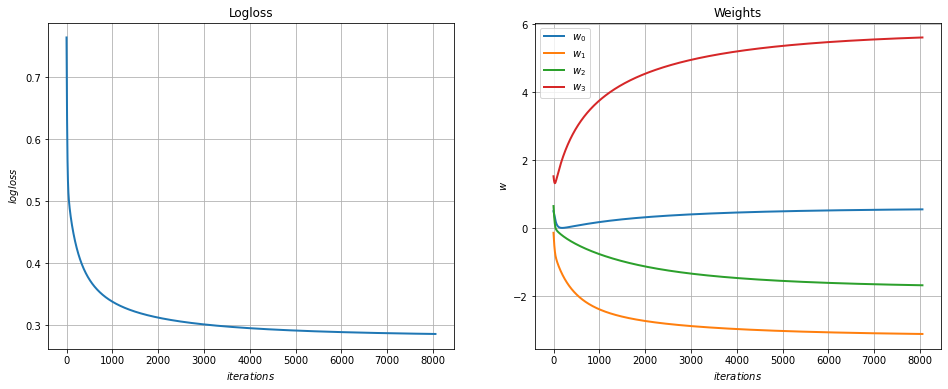

In [43]:
plot_history(w_hist, err_hist)

**L2-регуляризация:**

In [44]:
i, err, W, w_hist, err_hist = eval_model_l2(X, y, iterations=opt_iterations, alpha=opt_alpha, tol=tol, lambda_=1e-3)

print(f'При добавлении L2-регуляризации logloss = {err} количество итераций = {i} при точности {tol} и alpha = {opt_alpha}')

При добавлении L2-регуляризации logloss = 0.4078100001071774 количество итераций = 1455 при точности 1e-06 и alpha = 0.1


In [45]:
y_pred_proba(W, X)

array([0.31859953, 0.27585981, 0.82346001, 0.2967852 , 0.57554275,
       0.36606524, 0.90814274, 0.30725004, 0.32982071, 0.78310805])

In [46]:
y_pred = calc_pred(W, X)

y_pred

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [47]:
y_pred == y

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True])

In [48]:
accuracy(y, y_pred)

0.9

In [49]:
confusion_matrix(y, y_pred)

array([[4., 0.],
       [1., 5.]])

In [50]:
precision(y, y_pred)

1.0

In [51]:
recall(y, y_pred)

0.8

In [52]:
f1_score(y, y_pred)

0.888888888888889

In [53]:
W

array([ 0.07604079, -1.45150924, -0.49672087,  2.40139802])

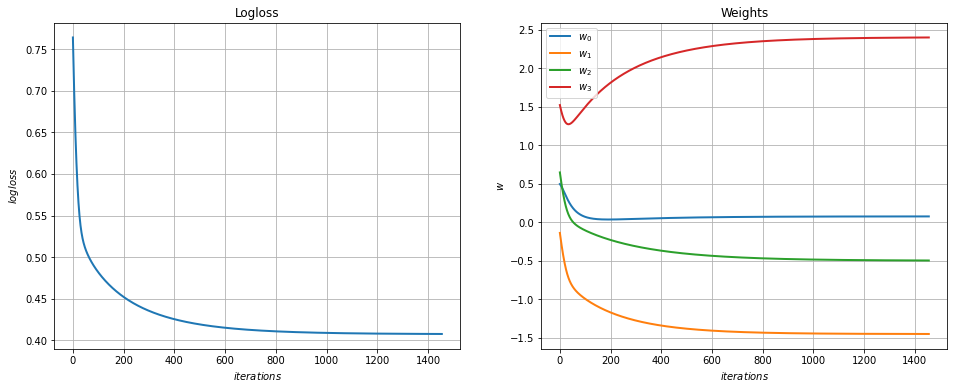

In [54]:
plot_history(w_hist, err_hist)

Применение регуляризации с теми же параметрами значительно сократило количество итераций при заданной точности, существенно снизило коэффициенты регрессии, а также сгладило явный выброс.